# Code cell 1:
First import all the libraries we might need and check if the GPU is running

In [16]:
import torch
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import random_split, DataLoader
print("PyTorch Version:", torch.__version__)
print("CUDA Version:", torch.version.cuda)
print("Is CUDA Available:", torch.cuda.is_available())
print("GPU Name:", torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

PyTorch Version: 1.10.2+cu113
CUDA Version: 11.3
Is CUDA Available: True
GPU Name: GeForce GTX 1080
Using device: cuda


# Code cell 2:
transform the data to tensors and normalize the images.
get the training and testing data, then split the training data to training (80%) then validation (20%).
then define the dataloaders to load the data in batches and after that show a portion of the images.

Files already downloaded and verified
Files already downloaded and verified
Training set size: 40000
Validation set size: 10000
Test set size: 10000


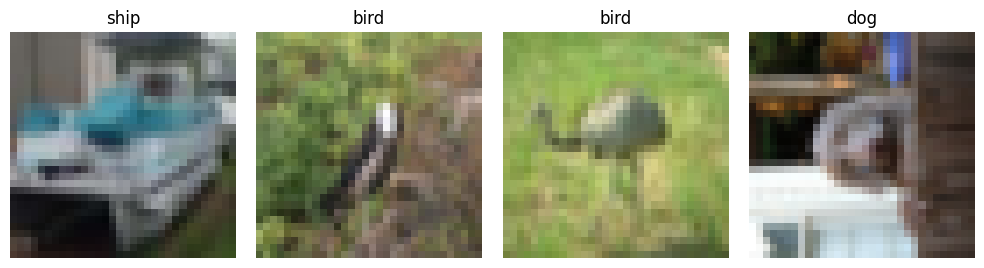

In [17]:
# transform the images to tensors and normalize them
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

# load the CIFAR-10 dataset
train_full = datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
test_set = datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)

# split the training set into training and validation sets
train_size = int(0.8 * len(train_full))
val_size = len(train_full) - train_size
train_set, val_set = random_split(train_full, [train_size, val_size])

# create data loaders
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)
val_loader = DataLoader(val_set, batch_size=64, shuffle=False)
test_loader = DataLoader(test_set, batch_size=64, shuffle=False)

# show some images
classes = ('plane', 'car', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck')

def show_images(loader):
    images, labels = next(iter(loader))
    images = images[:4]
    labels = labels[:4]
    
    images = images / 2 + 0.5
    
    plt.figure(figsize=(10, 10))
    for idx in range(4):
        plt.subplot(4, 4, idx+1)
        plt.imshow(images[idx].permute(1, 2, 0))
        plt.title(classes[labels[idx]])
        plt.axis('off')
    plt.tight_layout()
    plt.show()

print(f"Training set size: {len(train_set)}")
print(f"Validation set size: {len(val_set)}")
print(f"Test set size: {len(test_set)}")
show_images(train_loader)

# Code cell 3:
here we start with task 1 where we define a simple CNN, we first define the model by defining 2 convolutional layers with the appropriate inputs, then a max pooling layer, and at the end we define a fully connected layer.
Then we define the forward function that will apply the relu activation function on each layer and apply pooling and pass the data forward, basically defining the bhavior of the network.
after that we create a model and run it on the gpu, then we define the loss function and the optimizer.
after that we have the function that evaluates the model. It starts by training the model and evaluating it while storing the results in lists so that we can later plot the results.
The function trains the NN and it measures the loss to optimize it.
at the end we call the training function over the epochs and we plot the results.

Epoch [1/10], Train Loss: 1.5060, Train Acc: 0.4683, Val Acc: 0.5458, Test Acc: 0.5483
Epoch [2/10], Train Loss: 1.2031, Train Acc: 0.5790, Val Acc: 0.5831, Test Acc: 0.5890
Epoch [3/10], Train Loss: 1.0728, Train Acc: 0.6283, Val Acc: 0.6230, Test Acc: 0.6227
Epoch [4/10], Train Loss: 0.9951, Train Acc: 0.6546, Val Acc: 0.6427, Test Acc: 0.6467
Epoch [5/10], Train Loss: 0.9353, Train Acc: 0.6756, Val Acc: 0.6487, Test Acc: 0.6524
Epoch [6/10], Train Loss: 0.8862, Train Acc: 0.6946, Val Acc: 0.6628, Test Acc: 0.6679
Epoch [7/10], Train Loss: 0.8506, Train Acc: 0.7057, Val Acc: 0.6622, Test Acc: 0.6654
Epoch [8/10], Train Loss: 0.8187, Train Acc: 0.7174, Val Acc: 0.6703, Test Acc: 0.6720
Epoch [9/10], Train Loss: 0.7919, Train Acc: 0.7264, Val Acc: 0.6755, Test Acc: 0.6750
Epoch [10/10], Train Loss: 0.7655, Train Acc: 0.7357, Val Acc: 0.6694, Test Acc: 0.6625


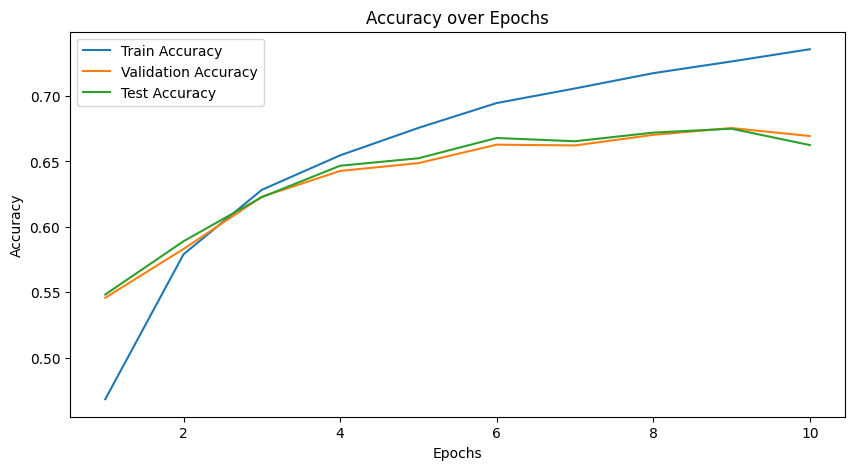

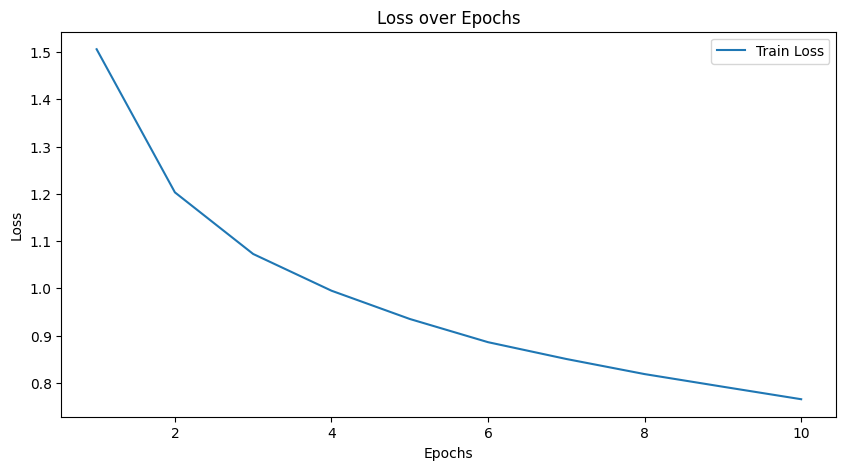

In [18]:
# define a simple CNN model
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 8 * 8, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = x.view(-1, 32 * 8 * 8)
        x = self.fc1(x)
        return x

# create the model, loss function, and optimizer
model = SimpleCNN().to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# train the model and validate it on the validation set after each epoch and test it on the test set after training
def train_validate_test(model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=10):
    train_losses = []
    train_accuracies = []
    val_accuracies = []
    test_accuracies = []

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        correct_train = 0
        total_train = 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            loss = criterion(outputs, labels)

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

            _, predicted = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (predicted == labels).sum().item()

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct_train / total_train

        train_losses.append(train_loss)
        train_accuracies.append(train_acc)

        model.eval()
        correct_val = 0
        total_val = 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_val += labels.size(0)
                correct_val += (predicted == labels).sum().item()
        val_acc = correct_val / total_val
        val_accuracies.append(val_acc)

        correct_test = 0
        total_test = 0
        with torch.no_grad():
            for images, labels in test_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                _, predicted = torch.max(outputs, 1)
                total_test += labels.size(0)
                correct_test += (predicted == labels).sum().item()
        test_acc = correct_test / total_test
        test_accuracies.append(test_acc)

        print(f"Epoch [{epoch+1}/{num_epochs}], "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, "
              f"Val Acc: {val_acc:.4f}, Test Acc: {test_acc:.4f}")

    return train_losses, train_accuracies, val_accuracies, test_accuracies

# train the model and plot the loss and accuracy over epochs
num_epochs = 10
train_losses, train_accuracies, val_accuracies, test_accuracies = train_validate_test(
    model, train_loader, val_loader, test_loader, criterion, optimizer, num_epochs=num_epochs
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies, label='Train Accuracy')
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy')
plt.plot(range(1, num_epochs + 1), test_accuracies, label='Test Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses, label='Train Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()


# Code cell 4:
Similar to what we did before, we didn't introduce anything new, except for the new NN, we added more layers and that's about it

Epoch [1/10], Train Loss: 1.6211, Train Acc: 0.4044, Val Acc: 0.5183, Test Acc: 0.5227
Epoch [2/10], Train Loss: 1.2407, Train Acc: 0.5547, Val Acc: 0.6000, Test Acc: 0.5999
Epoch [3/10], Train Loss: 1.0528, Train Acc: 0.6273, Val Acc: 0.6246, Test Acc: 0.6211
Epoch [4/10], Train Loss: 0.9177, Train Acc: 0.6790, Val Acc: 0.6572, Test Acc: 0.6536
Epoch [5/10], Train Loss: 0.8088, Train Acc: 0.7161, Val Acc: 0.6834, Test Acc: 0.6873
Epoch [6/10], Train Loss: 0.7287, Train Acc: 0.7466, Val Acc: 0.6789, Test Acc: 0.6795
Epoch [7/10], Train Loss: 0.6515, Train Acc: 0.7735, Val Acc: 0.7105, Test Acc: 0.7061
Epoch [8/10], Train Loss: 0.5847, Train Acc: 0.7978, Val Acc: 0.7073, Test Acc: 0.7010
Epoch [9/10], Train Loss: 0.5268, Train Acc: 0.8155, Val Acc: 0.7199, Test Acc: 0.7106
Epoch [10/10], Train Loss: 0.4739, Train Acc: 0.8351, Val Acc: 0.7304, Test Acc: 0.7152


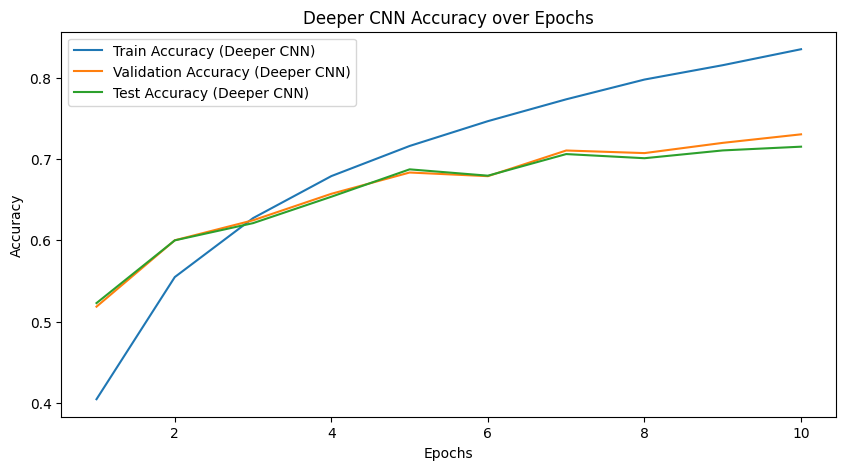

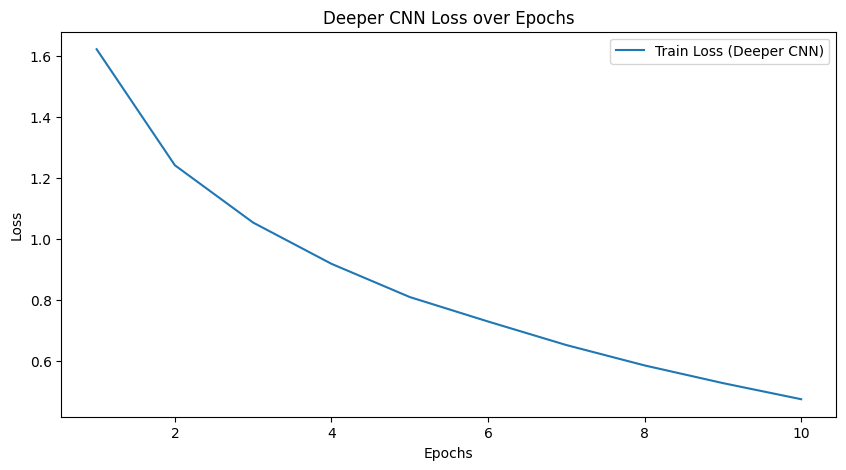

In [19]:
class DeeperCNN(nn.Module):
    def __init__(self):
        super(DeeperCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 2 * 2, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = self.fc1(x)
        return x

model_deeper = DeeperCNN().to(device)
criterion_deeper = nn.CrossEntropyLoss()
optimizer_deeper = optim.Adam(model_deeper.parameters(), lr=0.001)

num_epochs = 10
train_losses_deeper, train_accuracies_deeper, val_accuracies_deeper, test_accuracies_deeper = train_validate_test(
    model_deeper, train_loader, val_loader, test_loader, criterion_deeper, optimizer_deeper, num_epochs=num_epochs
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies_deeper, label='Train Accuracy (Deeper CNN)')
plt.plot(range(1, num_epochs + 1), val_accuracies_deeper, label='Validation Accuracy (Deeper CNN)')
plt.plot(range(1, num_epochs + 1), test_accuracies_deeper, label='Test Accuracy (Deeper CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Deeper CNN Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_deeper, label='Train Loss (Deeper CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Deeper CNN Loss over Epochs')
plt.legend()
plt.show()


# Code cell 5:
similar to what we did before as well, we only changed the kernel size and did the exact same steps as before

Epoch [1/10], Train Loss: 1.6100, Train Acc: 0.4250, Val Acc: 0.5007, Test Acc: 0.5028
Epoch [2/10], Train Loss: 1.3171, Train Acc: 0.5358, Val Acc: 0.5519, Test Acc: 0.5568
Epoch [3/10], Train Loss: 1.1977, Train Acc: 0.5793, Val Acc: 0.5608, Test Acc: 0.5625
Epoch [4/10], Train Loss: 1.1265, Train Acc: 0.6045, Val Acc: 0.5887, Test Acc: 0.5931
Epoch [5/10], Train Loss: 1.0764, Train Acc: 0.6221, Val Acc: 0.6042, Test Acc: 0.6064
Epoch [6/10], Train Loss: 1.0378, Train Acc: 0.6356, Val Acc: 0.6088, Test Acc: 0.6083
Epoch [7/10], Train Loss: 1.0043, Train Acc: 0.6492, Val Acc: 0.6034, Test Acc: 0.6094
Epoch [8/10], Train Loss: 0.9779, Train Acc: 0.6600, Val Acc: 0.6130, Test Acc: 0.6223
Epoch [9/10], Train Loss: 0.9542, Train Acc: 0.6654, Val Acc: 0.6138, Test Acc: 0.6166
Epoch [10/10], Train Loss: 0.9381, Train Acc: 0.6725, Val Acc: 0.6187, Test Acc: 0.6214


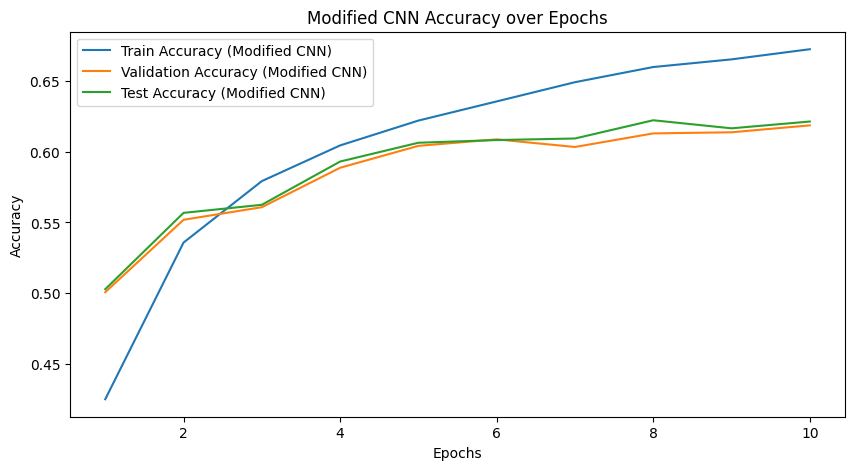

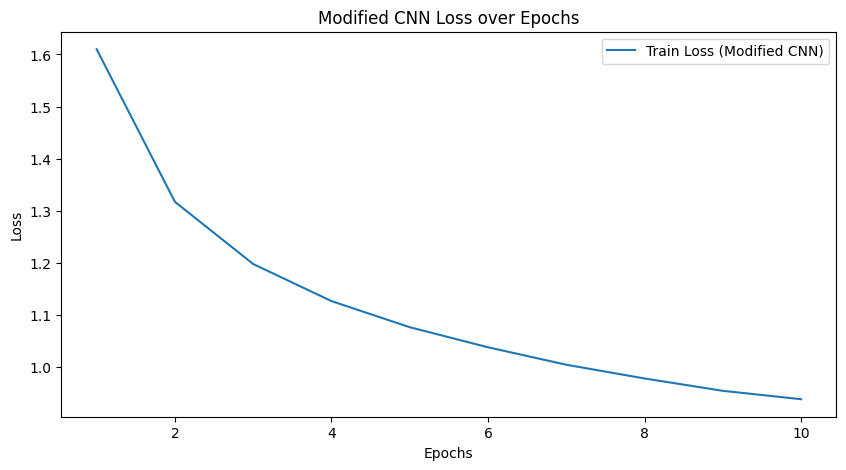

In [20]:
class ModifiedCNN(nn.Module):
    def __init__(self):
        super(ModifiedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=5, stride=2, padding=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=5, stride=2, padding=2) 
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(32 * 4 * 4, 10)

    def forward(self, x):
        x = torch.relu(self.conv1(x))
        x = torch.relu(self.conv2(x))
        x = self.pool(x)
        x = x.view(-1, 32 * 4 * 4)
        x = self.fc1(x)
        return x

model_modified = ModifiedCNN().to(device)
criterion_modified = nn.CrossEntropyLoss()
optimizer_modified = optim.Adam(model_modified.parameters(), lr=0.001)

num_epochs = 10
train_losses_modified, train_accuracies_modified, val_accuracies_modified, test_accuracies_modified = train_validate_test(
    model_modified, train_loader, val_loader, test_loader, criterion_modified, optimizer_modified, num_epochs=num_epochs
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies_modified, label='Train Accuracy (Modified CNN)')
plt.plot(range(1, num_epochs + 1), val_accuracies_modified, label='Validation Accuracy (Modified CNN)')
plt.plot(range(1, num_epochs + 1), test_accuracies_modified, label='Test Accuracy (Modified CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Modified CNN Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_modified, label='Train Loss (Modified CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Modified CNN Loss over Epochs')
plt.legend()
plt.show()


# Code cell 6:
here as well, we did everything we did before, but we took the best NN that we had in terms of accuracy and then applied average pooling instead of max pooling

Epoch [1/10], Train Loss: 1.7132, Train Acc: 0.3719, Val Acc: 0.4528, Test Acc: 0.4560
Epoch [2/10], Train Loss: 1.3818, Train Acc: 0.4994, Val Acc: 0.5289, Test Acc: 0.5326
Epoch [3/10], Train Loss: 1.2402, Train Acc: 0.5558, Val Acc: 0.5644, Test Acc: 0.5676
Epoch [4/10], Train Loss: 1.1398, Train Acc: 0.5925, Val Acc: 0.6040, Test Acc: 0.6092
Epoch [5/10], Train Loss: 1.0596, Train Acc: 0.6231, Val Acc: 0.6373, Test Acc: 0.6318
Epoch [6/10], Train Loss: 0.9899, Train Acc: 0.6481, Val Acc: 0.6483, Test Acc: 0.6518
Epoch [7/10], Train Loss: 0.9336, Train Acc: 0.6694, Val Acc: 0.6461, Test Acc: 0.6454
Epoch [8/10], Train Loss: 0.8886, Train Acc: 0.6839, Val Acc: 0.6615, Test Acc: 0.6654
Epoch [9/10], Train Loss: 0.8431, Train Acc: 0.7016, Val Acc: 0.6678, Test Acc: 0.6694
Epoch [10/10], Train Loss: 0.7975, Train Acc: 0.7184, Val Acc: 0.6728, Test Acc: 0.6758


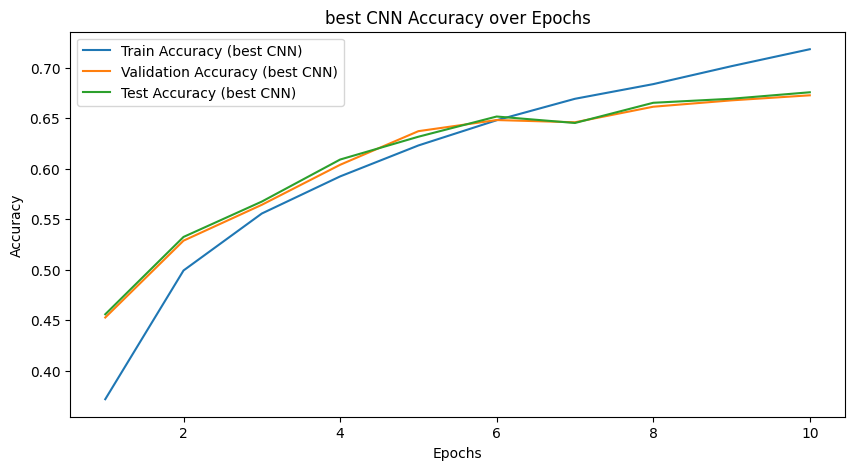

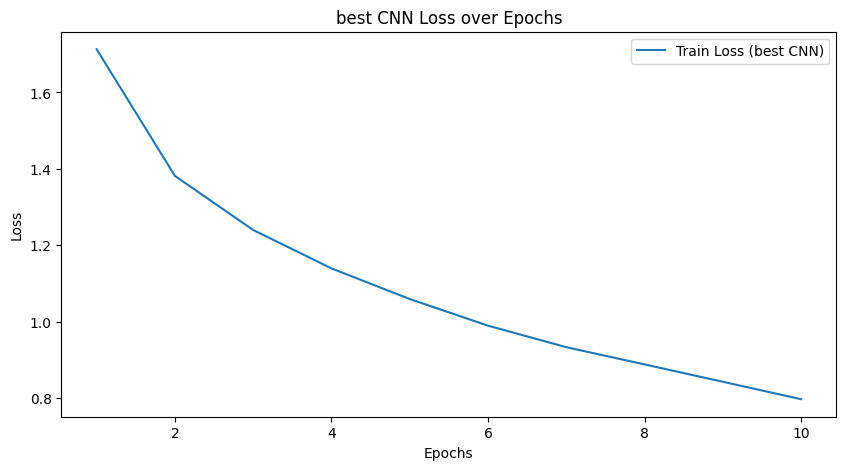

In [21]:
class BestCNN(nn.Module):
    def __init__(self):
        super(BestCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1)
        self.conv4 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AvgPool2d(kernel_size=2, stride=2)
        self.fc1 = nn.Linear(128 * 2 * 2, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = self.pool(torch.relu(self.conv3(x)))
        x = self.pool(torch.relu(self.conv4(x)))
        x = x.view(-1, 128 * 2 * 2)
        x = self.fc1(x)
        return x

model_best_cnn = BestCNN().to(device)
criterion_best_cnn = nn.CrossEntropyLoss()
optimizer_best_cnn = optim.Adam(model_best_cnn.parameters(), lr=0.001)

num_epochs = 10
train_losses_deeper, train_accuracies_deeper, val_accuracies_deeper, test_accuracies_deeper = train_validate_test(
    model_best_cnn, train_loader, val_loader, test_loader, criterion_best_cnn, optimizer_best_cnn, num_epochs=num_epochs
)

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_accuracies_deeper, label='Train Accuracy (best CNN)')
plt.plot(range(1, num_epochs + 1), val_accuracies_deeper, label='Validation Accuracy (best CNN)')
plt.plot(range(1, num_epochs + 1), test_accuracies_deeper, label='Test Accuracy (best CNN)')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('best CNN Accuracy over Epochs')
plt.legend()
plt.show()

plt.figure(figsize=(10, 5))
plt.plot(range(1, num_epochs + 1), train_losses_deeper, label='Train Loss (best CNN)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('best CNN Loss over Epochs')
plt.legend()
plt.show()
